In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.16.1'

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

## Q1/Load and prepare the MNIST dataset.

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Q2/Create the Generator.

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

D:\aldul\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


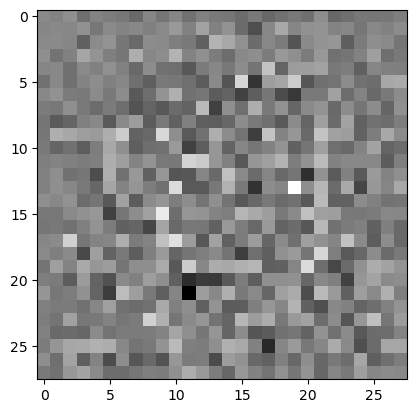

In [9]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Q3/Create the discriminator.

In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00084663]], shape=(1, 1), dtype=float32)


D:\aldul\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


## Q4/Define the loss and optimizers.

In [12]:

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
print(generator)
print(discriminator)


<Sequential name=sequential, built=True>
<Sequential name=sequential_1, built=True>


In [18]:
import tensorflow as tf


generator = make_generator_model()
discriminator = make_discriminator_model()


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


checkpoint_dir = r'C:\Users\aldul\Downloads\DSCI 619_Deep_learning\training_checkpoints'


generator_save_path = os.path.join(checkpoint_dir, "generator")
tf.saved_model.save(generator, generator_save_path)


discriminator_save_path = os.path.join(checkpoint_dir, "discriminator")
tf.saved_model.save(discriminator, discriminator_save_path)


INFO:tensorflow:Assets written to: C:\Users\aldul\Downloads\DSCI 619_Deep_learning\training_checkpoints\generator\assets


INFO:tensorflow:Assets written to: C:\Users\aldul\Downloads\DSCI 619_Deep_learning\training_checkpoints\generator\assets


INFO:tensorflow:Assets written to: C:\Users\aldul\Downloads\DSCI 619_Deep_learning\training_checkpoints\discriminator\assets


INFO:tensorflow:Assets written to: C:\Users\aldul\Downloads\DSCI 619_Deep_learning\training_checkpoints\discriminator\assets


## Q5/Define the training loop

In [19]:

import tensorflow as tf


EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [20]:

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
     
        generated_images = generator(noise, training=True)

     
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

       
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [21]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

       
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)


In [22]:
import matplotlib.pyplot as plt

def generate_and_save_images(model, epoch, test_input):
 
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


## Q6/Train the model

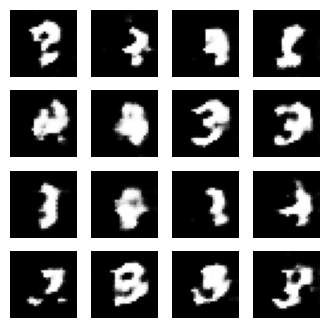

In [23]:
import time
import matplotlib.pyplot as plt
from IPython import display


EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16


seed = tf.random.normal([num_examples_to_generate, noise_dim])


def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

   
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)


def generate_and_save_images(model, epoch, test_input):
   
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


train(train_dataset, EPOCHS)


In [24]:
import tensorflow as tf


generator = make_generator_model()
discriminator = make_discriminator_model()


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


checkpoint_dir = r'C:\Users\aldul\Downloads\DSCI 619_Deep_learning\training_checkpoints'


generator_save_path = os.path.join(checkpoint_dir, "generator")
tf.saved_model.save(generator, generator_save_path)


discriminator_save_path = os.path.join(checkpoint_dir, "discriminator")
tf.saved_model.save(discriminator, discriminator_save_path)


D:\aldul\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
D:\aldul\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


INFO:tensorflow:Assets written to: C:\Users\aldul\Downloads\DSCI 619_Deep_learning\training_checkpoints\generator\assets


INFO:tensorflow:Assets written to: C:\Users\aldul\Downloads\DSCI 619_Deep_learning\training_checkpoints\generator\assets


INFO:tensorflow:Assets written to: C:\Users\aldul\Downloads\DSCI 619_Deep_learning\training_checkpoints\discriminator\assets


INFO:tensorflow:Assets written to: C:\Users\aldul\Downloads\DSCI 619_Deep_learning\training_checkpoints\discriminator\assets


## Q7/Create a GIF.

In [25]:
import PIL

def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))



In [26]:
display_image(EPOCHS).show()


In [27]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

C:\Users\aldul\AppData\Local\Temp\ipykernel_6500\1982054950.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\aldul\AppData\Local\Temp\ipykernel_6500\1982054950.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



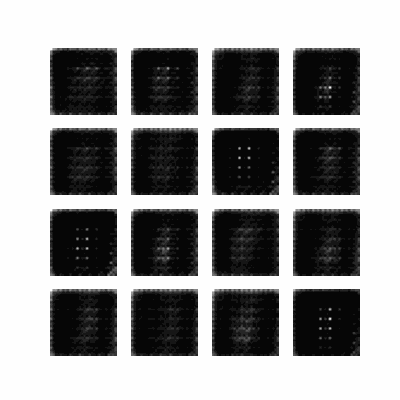

In [28]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)